In [1]:
# pip install librosa
# pip install matplotlib
# pip install pandas
# pip install tqdm
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import joblib

#### Configuración del dataset

In [194]:
DATASET_PATH = "data/genres_original/"
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 
          'metal', 'pop', 'reggae', 'rock']
SAMPLE_RATE = 22050 
DURATION = 30  
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

#### Procesamiento del dataset y extracción de coeficientes MFCCs

In [ ]:
def extract_features(dataset_path, genres, n_mfcc=20, segment_duration=10):
    data = {
        "genre": [],
        "mfcc": [],
        "filename": []
    }
    
    samples_per_segment = SAMPLE_RATE * segment_duration
    num_segments = DURATION // segment_duration  
    
    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        print(f"Procesando género: {genre}")
        
        for file_name in tqdm(os.listdir(genre_path)):
            file_path = os.path.join(genre_path, file_name)
            
            try:
                # Cargar el archivo de audio
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
                
                # Dividir en segmentos y extraer características
                for segment in range(num_segments):
                    start_sample = segment * samples_per_segment
                    end_sample = start_sample + samples_per_segment
                    
                    # Verificar si el segmento tiene suficientes muestras
                    if len(signal[start_sample:end_sample]) == samples_per_segment:
                        # Extraer MFCCs del segmento
                        mfcc = librosa.feature.mfcc(
                            y=signal[start_sample:end_sample], 
                            sr=sr, 
                            n_mfcc=n_mfcc
                        )
                        mfcc_mean = np.mean(mfcc.T, axis=0)  # Usar la media de las características
                        
                        # Guardar en el diccionario
                        data["genre"].append(genre)
                        data["mfcc"].append(mfcc_mean)
                        data["filename"].append(f"{file_name}_segment{segment}")
            except Exception as e:
                print(f"Error procesando {file_path}: {e}")
                
    return pd.DataFrame(data)


In [196]:
# Extraer características
df = extract_features(DATASET_PATH, GENRES)

# Guardar en un archivo CSV
df.to_csv("features_gtzan.csv", index=False)
print("Archivo 'features_gtzan.csv' guardado exitosamente.")

Procesando género: blues


100%|██████████| 100/100 [00:03<00:00, 29.14it/s]


Procesando género: classical


100%|██████████| 100/100 [00:03<00:00, 28.95it/s]


Procesando género: country


100%|██████████| 100/100 [00:03<00:00, 28.80it/s]


Procesando género: disco


100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Procesando género: hiphop


100%|██████████| 100/100 [00:03<00:00, 25.38it/s]


Procesando género: jazz


 53%|█████▎    | 53/100 [00:01<00:01, 27.50it/s]C:\Users\alexa\AppData\Local\Temp\ipykernel_15752\2451622452.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
c:\Users\alexa\Desktop\proyectos_python\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 57%|█████▋    | 57/100 [00:01<00:01, 30.33it/s]

Error procesando data/genres_original/jazz\jazz.00054.wav: 


100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Procesando género: metal


100%|██████████| 100/100 [00:03<00:00, 30.15it/s]


Procesando género: pop


100%|██████████| 100/100 [00:03<00:00, 30.48it/s]


Procesando género: reggae


100%|██████████| 100/100 [00:03<00:00, 29.75it/s]


Procesando género: rock


100%|██████████| 100/100 [00:03<00:00, 30.00it/s]


Archivo 'features_gtzan.csv' guardado exitosamente.


In [197]:
df = pd.read_csv("features_gtzan.csv")
df

,genre,mfcc,filename
0,blues,[-125.25643 120.20559 -18.326477 4...,blues.00000.wav_segment0
1,blues,[-104.70713 122.2818 -16.140684 4...,blues.00000.wav_segment1
2,blues,[-113.05592 125.08428 -25.844616 4...,blues.00000.wav_segment2
3,blues,[-2.21962158e+02 1.31098083e+02 5.16325712e-...,blues.00001.wav_segment0
4,blues,[-2.22065689e+02 1.24184708e+02 1.12355490e+...,blues.00001.wav_segment1
...,...,...,...
2983,rock,[-162.91974 124.22265 -25.009153 5...,rock.00098.wav_segment1
2984,rock,[-3.1373584e+02 1.2400946e+02 6.2209702e+00 ...,rock.00098.wav_segment2
2985,rock,[-257.21103 122.03897 -23.428373 5...,rock.00099.wav_segment0
2986,rock,[-221.25838 128.92293 -20.93692 48.7...,rock.00099.wav_segment1


In [198]:
df['genre'].value_counts()

genre
blues        300
pop          300
metal        300
reggae       300
rock         299
disco        299
classical    298
hiphop       298
jazz         297
country      297
Name: count, dtype: int64

#### Partición del dataset

In [199]:
# Convertir la columna 'mfcc' de cadenas a arrays NumPy
X = np.array([np.fromstring(row[1:-1], sep=' ') for row in df['mfcc']])
y = np.array(df["genre"].tolist())

# Convertir etiquetas a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Estandarizar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")


Tamaño del conjunto de entrenamiento: 2539
Tamaño del conjunto de prueba: 449


#### Modelos de ML

In [ ]:
# pip install seaborn
# pip install xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

#### 1er MLM: Random Forest

In [202]:
# Crear el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=200)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

Reporte de prueba:
              precision    recall  f1-score   support

       blues       0.87      0.89      0.88        45
   classical       0.95      0.91      0.93        45
     country       0.79      0.67      0.72        45
       disco       0.71      0.76      0.73        45
      hiphop       0.80      0.71      0.75        45
        jazz       0.85      0.77      0.81        44
       metal       0.81      0.96      0.88        45
         pop       0.80      0.96      0.87        45
      reggae       0.76      0.87      0.81        45
        rock       0.69      0.56      0.62        45

    accuracy                           0.80       449
   macro avg       0.80      0.80      0.80       449
weighted avg       0.80      0.80      0.80       449



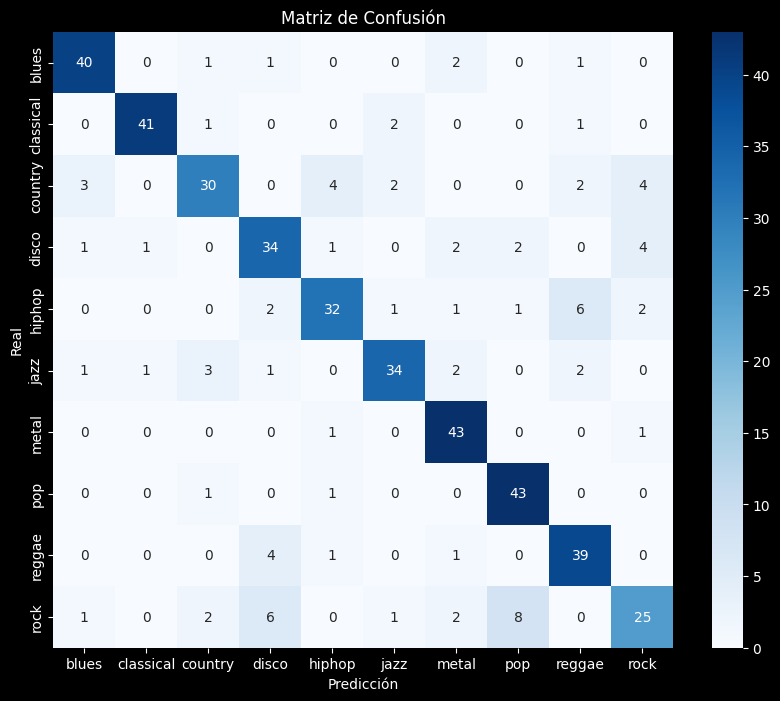

Modelo guardado como 'random_forest_genre_classifier.pkl'


In [203]:
# Evaluar en los datos de prueba
y_test_pred = rf_model.predict(X_test)
print("Reporte de prueba:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Guardar el modelo entrenado
joblib.dump(rf_model, "random_forest_genre_classifier.pkl")
print("Modelo guardado como 'random_forest_genre_classifier.pkl'")

#### 2do MLM: XgBoost

Reporte de prueba:
              precision    recall  f1-score   support

       blues       0.85      0.89      0.87        45
   classical       0.93      0.84      0.88        45
     country       0.78      0.64      0.71        45
       disco       0.80      0.73      0.77        45
      hiphop       0.64      0.71      0.67        45
        jazz       0.77      0.75      0.76        44
       metal       0.81      0.87      0.84        45
         pop       0.88      0.93      0.90        45
      reggae       0.72      0.76      0.74        45
        rock       0.66      0.69      0.67        45

    accuracy                           0.78       449
   macro avg       0.78      0.78      0.78       449
weighted avg       0.78      0.78      0.78       449



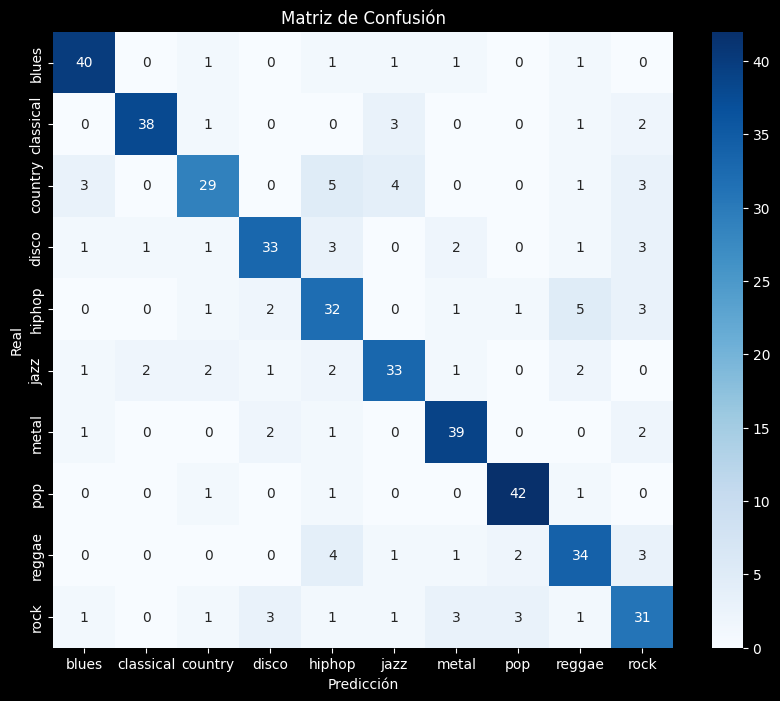

Modelo guardado como 'xgboost_genre_classifier.pkl'


In [206]:
# Crear el modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Evaluar en los datos de prueba
y_test_pred = xgb_model.predict(X_test)
print("Reporte de prueba:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Guardar el modelo entrenado
joblib.dump(xgb_model, "xgboost_genre_classifier.pkl")
print("Modelo guardado como 'xgboost_genre_classifier.pkl'")

#### 3er MLM: K Nearest Neighbors

Reporte de prueba:
              precision    recall  f1-score   support

       blues       0.85      0.91      0.88        45
   classical       0.85      0.87      0.86        45
     country       0.64      0.64      0.64        45
       disco       0.63      0.71      0.67        45
      hiphop       0.67      0.76      0.71        45
        jazz       0.75      0.68      0.71        44
       metal       0.90      0.82      0.86        45
         pop       0.75      0.84      0.79        45
      reggae       0.84      0.71      0.77        45
        rock       0.66      0.56      0.60        45

    accuracy                           0.75       449
   macro avg       0.75      0.75      0.75       449
weighted avg       0.75      0.75      0.75       449



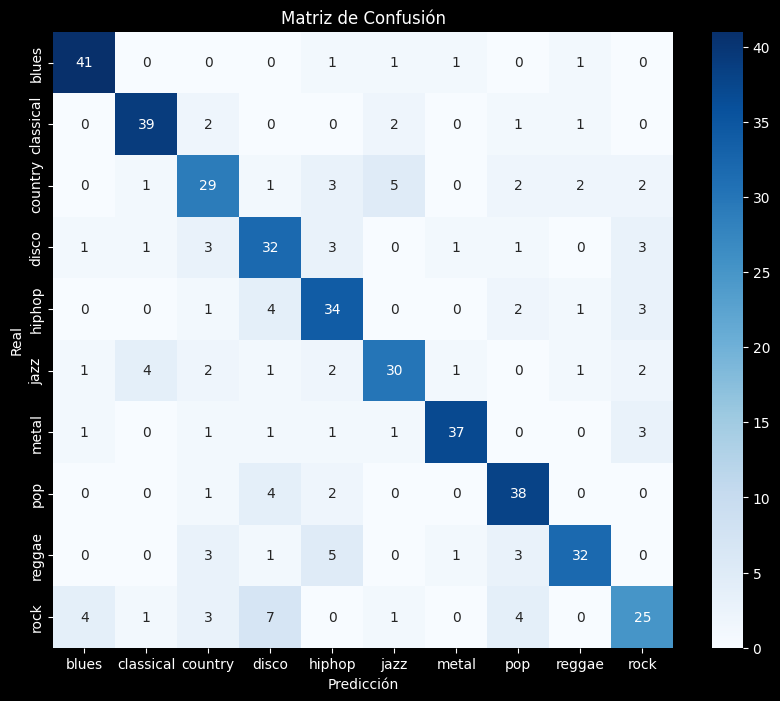

Modelo guardado como 'knn_genre_classifier.pkl'


In [ ]:
# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Entrenar el modelo
knn_model.fit(X_train, y_train)

# Evaluar en los datos de prueba
y_test_pred = knn_model.predict(X_test)
print("Reporte de prueba:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Guardar el modelo entrenado
joblib.dump(knn_model, "knn_genre_classifier.pkl")
print("Modelo guardado como 'knn_genre_classifier.pkl'")

#### KPIs (Accuracy)

In [ ]:
import time
from sklearn import metrics
# Modelo 1: Random Forest
t1_rf = time.time()
rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(X_train, y_train)
t2_rf = time.time()
y_forecast_rf = rf_model.predict(X_test)
accuracy_rf = metrics.accuracy_score(y_test, y_forecast_rf)

# Imprimir los resultados
print("""
Modelo: Random Forest
  KPI (Accuracy): %.3f
  Tiempo de procesamiento (fit): %f segundos
""" %(accuracy_rf, t2_rf - t1_rf))


Modelo: Random Forest
  KPI (Accuracy): 0.795
  Tiempo de procesamiento (fit): 0.855348 segundos



In [210]:
# Modelo 2: XGBoost
t1_xgb = time.time()
xgb_model = XGBClassifier(n_estimators=100)
xgb_model.fit(X_train, y_train)
t2_xgb = time.time()
y_forecast_xgb = xgb_model.predict(X_test)
accuracy_xgb = metrics.accuracy_score(y_test, y_forecast_xgb)

print("""
Modelo: XGBoost
  KPI (Accuracy): %.3f
  Tiempo de procesamiento (fit): %f segundos
""" %(accuracy_xgb, t2_xgb - t1_xgb))


Modelo: XGBoost
  KPI (Accuracy): 0.782
  Tiempo de procesamiento (fit): 0.666584 segundos



In [211]:
# Modelo 3: KNN
t1_knn = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
t2_knn = time.time()
y_forecast_knn = knn_model.predict(X_test)
accuracy_knn = metrics.accuracy_score(y_test, y_forecast_knn)


print("""
Modelo: KNN
  KPI (Accuracy): %.3f
  Tiempo de procesamiento (fit): %f segundos
""" %(accuracy_knn, t2_knn - t1_knn))


Modelo: KNN
  KPI (Accuracy): 0.751
  Tiempo de procesamiento (fit): 0.000976 segundos



#### Barrido de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
# Random Forest
# Definimos un diccionario con los argumentos y valores a considerar
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [10, 20, 30],        # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'criterion': ['gini', 'entropy'] # Criterio para medir la calidad de las divisiones
}

# Modelo base de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2)

# Ajustar el modelo con GridSearch
grid_rf.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados por GridSearch
print("Mejores hiperparámetros para Random Forest:", grid_rf.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_rf = grid_rf.best_estimator_
print("Accuracy en test set:", best_rf.score(X_test, y_test))

# Guardar el mejor modelo en un archivo para futuras predicciones
joblib.dump(best_rf, "best_random_forest_model.pkl")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimato

['best_random_forest_model.pkl']

In [216]:
# XgBoost
# Definimos un diccionario con los argumentos y valores a considerar
param_grid_xgb = {
    'n_estimators': [50, 100, 200],    # Número de árboles
    'max_depth': [3, 6, 10],            # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
    'subsample': [0.8, 1.0],            # Submuestra de datos
    'colsample_bytree': [0.8, 1.0]      # Submuestra de columnas por árbol
}

# Modelo base de XGBoost
xgb_model = XGBClassifier(random_state=42)

# Configurar GridSearchCV
grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=2)

# Ajustar el modelo con GridSearch
grid_xgb.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados por GridSearch
print("Mejores hiperparámetros para XGBoost:", grid_xgb.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_xgb = grid_xgb.best_estimator_
print("Accuracy en test set:", best_xgb.score(X_test, y_test))

# Guardar el mejor modelo en un archivo para futuras predicciones
joblib.dump(best_xgb, "best_xgboost_model.pkl")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsampl

['best_xgboost_model.pkl']

In [217]:
# KNN
# Definimos un diccionario con los argumentos y valores a considerar
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],         # Número de vecinos a considerar
    'weights': ['uniform', 'distance'],   # Tipo de ponderación
    'metric': ['euclidean', 'manhattan']  # Métricas de distancia
}

# Modelo base de KNN
knn_model = KNeighborsClassifier()

# Configurar GridSearchCV
grid_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, cv=5, scoring='accuracy', verbose=2)

# Ajustar el modelo con GridSearch
grid_knn.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados por GridSearch
print("Mejores hiperparámetros para KNN:", grid_knn.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_knn = grid_knn.best_estimator_
print("Accuracy en test set:", best_knn.score(X_test, y_test))

# Guardar el mejor modelo en un archivo para futuras predicciones
joblib.dump(best_knn, "best_knn_model.pkl")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, wei

['best_knn_model.pkl']

#### Evaluación y comparación de modelos

In [219]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los tres modelos
best_rf_model = joblib.load('best_random_forest_model.pkl')
best_xgb_model = joblib.load('best_xgboost_model.pkl')
best_knn_model = joblib.load('best_knn_model.pkl')

# Hacer predicciones con cada modelo
y_pred_rf = best_rf_model.predict(X_test)
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_knn = best_knn_model.predict(X_test)

# Evaluar cada modelo con classification_report
print("Reporte de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

print("Reporte de clasificación para XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

print("Reporte de clasificación para KNN:")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))


Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

       blues       0.87      0.89      0.88        45
   classical       0.93      0.87      0.90        45
     country       0.79      0.60      0.68        45
       disco       0.71      0.80      0.75        45
      hiphop       0.87      0.73      0.80        45
        jazz       0.80      0.80      0.80        44
       metal       0.81      0.96      0.88        45
         pop       0.80      0.98      0.88        45
      reggae       0.80      0.87      0.83        45
        rock       0.76      0.62      0.68        45

    accuracy                           0.81       449
   macro avg       0.81      0.81      0.81       449
weighted avg       0.81      0.81      0.81       449

Reporte de clasificación para XGBoost:
              precision    recall  f1-score   support

       blues       0.82      0.80      0.81        45
   classical       0.90      0.84      0.87     

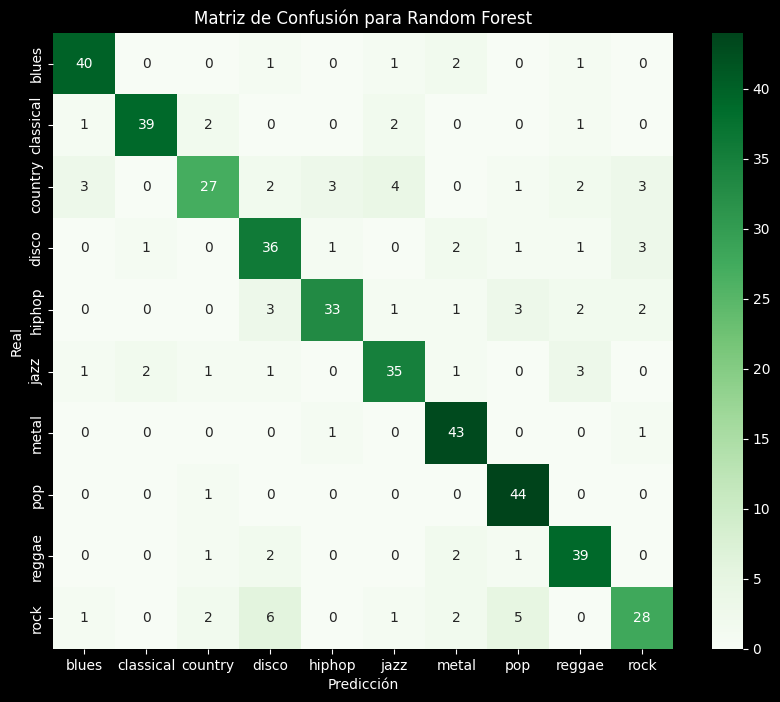

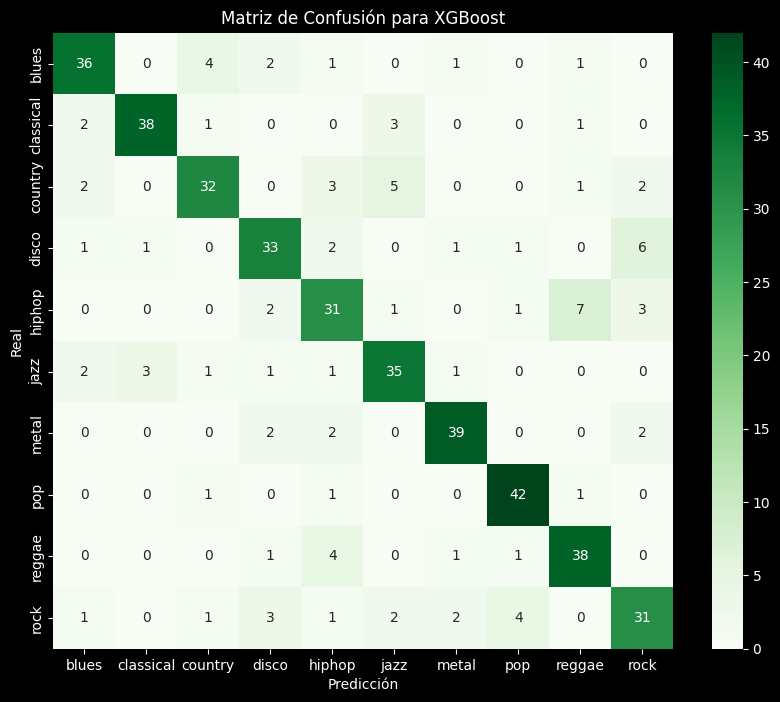

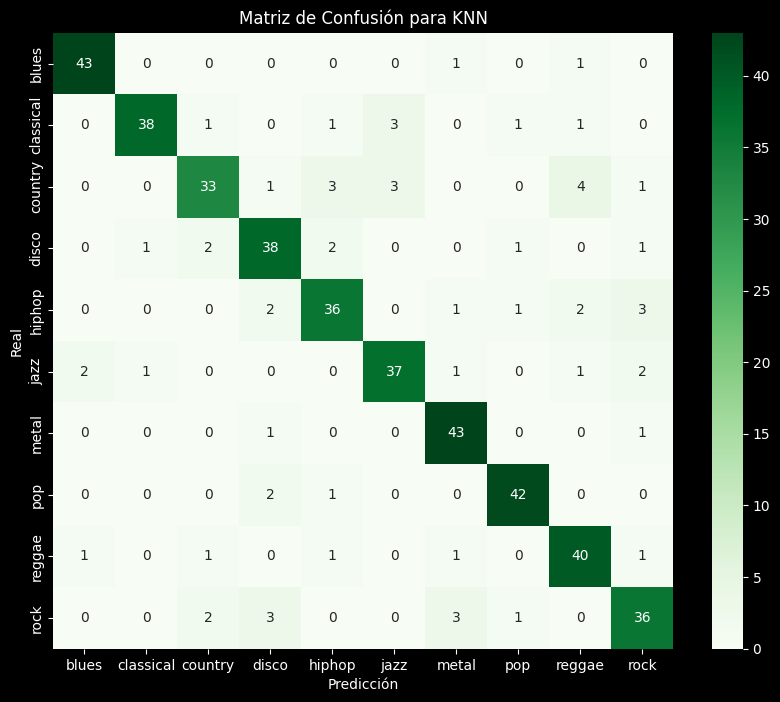

In [222]:
# Matriz de confusión para cada modelo
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, cmap='Greens')
    plt.title(f'Matriz de Confusión para {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Mostrar las matrices de confusión
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')
plot_confusion_matrix(y_test, y_pred_knn, 'KNN')